In [1]:
#vampyr setup

from vampyr import vampyr3d as vp
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy.integrate as integrate
from scipy.special import legendre, laguerre, erf, gamma
from scipy.special import gamma
from scipy.constants import hbar
from vampyr import InterpolatingBasis, project, apply, build_grid, multiply
from vampyr import copy_func, copy_grid, add, dot, gradient, refine_grid

# Parameters:
min_scale = -4
max_depth = 25
order = 8
prec = 1e-5
corner = [-1, -1, -1]
boxes = [2, 2, 2]

# origin moved to avoid placing the nuclar charge on a node
origin = [0.1, 0.2, 0.3]

# MRA World setup
world = vp.BoundingBox(min_scale, corner, boxes)
basis = InterpolatingBasis(order)
MRA = vp.MultiResolutionAnalysis(world, basis, max_depth)

0.6613878614971826 -5583.9425981964805


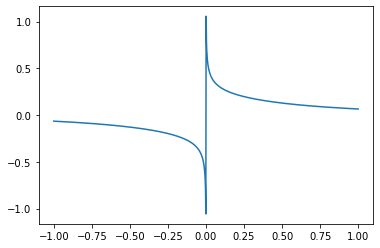

In [11]:
# H atom (almost) according to wikipedia
# Normalization not considered
# Exponential coeffcient C=1 (wikipedia coeff is not compatible with eigensolution)
# Limited to ground state for now (some formulas are however more generic)
# So far the best general description for the 4-c H atom was in the Bethe&Salpeter book

c=137.035999
alpha = 1.0/c
k = -1
l = 0
n = 1
m = 0.5
Z = 92

def compute_gamma(k,Z,alpha):
    return np.sqrt(k**2 - Z**2 * alpha**2)

def compute_dirac_energy(n,Z,k,alpha):
    gamma_factor = compute_gamma(k,Z,alpha)
    tmp1 = n - np.abs(k) + gamma_factor
    tmp2 = Z * alpha / tmp1
    tmp3 = 1 + tmp2**2
    return c**2 / np.sqrt(tmp3)
#
# Approx expression
#
#def compute_dirac_energy(n,Z,k,c):
#    tmp1 = 1.0/np.abs(k) - 3.0/(4*n)
#    tmp2 = 1 + tmp1 * Z**2 / (n * c**2)
#    return c**2 - tmp2 * Z**2 / (2*n**2)


def compute_norm_const(n, gamma_factor):
# THIS NORMALIZATION CONSTANT IS FROM WIKIPEDIA BUT IT DOES NOT AGREE WITH Bethe&Salpeter
    tmp1 = 2 * n * (n + gamma_factor)
    tmp2 = 1 / (gamma_factor * gamma(2 * gamma_factor))
    return np.sqrt(tmp2/tmp1)

def one_s_alpha(x,Z,alpha,gamma_factor):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    tmp1 = 1.0 + gamma_factor
    tmp4 = Z * alpha
    u = x/r
    lar =   tmp1
    sai =   tmp4 * u[2]
    sbr = - tmp4 * u[1]
    sbi =   tmp4 * u[0]
    return lar, 0, 0, 0, 0, sai, sbr, sbi

def one_s_alpha_comp(x,Z,alpha,gamma_factor,norm_const,comp):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    tmp2 = r ** (gamma_factor - 1)
    tmp3 = np.exp(-r)
    values = one_s_alpha(x,Z,alpha,gamma_factor)
    return values[comp] * tmp2 * tmp3 * norm_const / np.sqrt(2*np.pi)
                
gamma_factor = compute_gamma(k,Z,alpha)
norm_const = compute_norm_const(n, gamma_factor)
energy = compute_dirac_energy(n,Z,k,alpha)
Ezora = 2*(energy-c**2)*c**2/(energy+c**2)
print(norm_const,Ezora)

x_plt = np.linspace(-1.0, 1.0, 1000)
y_plt = [one_s_alpha_comp([x,0.0,0.0],Z,alpha,gamma_factor,norm_const,7) for x in x_plt]
_ = plt.plot(x_plt, y_plt)

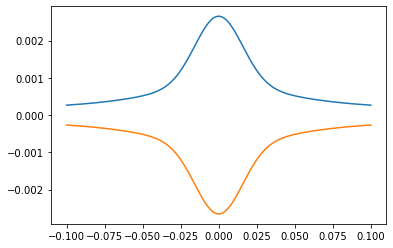

In [3]:
def u(r):
    u = erf(r)/r + (1/(3*np.sqrt(np.pi)))*(np.exp(-(r**2)) + 16*np.exp(-4*r**2))
    #erf(r) is an error function that is supposed to stop the potential well from going to inf.
    #if i remember correctly
    return u

def V(x):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    c = 0.0435
#    c = 0.000435 # ten times tighter nuclear potential
    f_bar = u(r/c)/c
    return f_bar

def kappa(x):
    temp = V(x) / (2 * c**2)
    return 1.0/(1-temp)

def one_m_kappa(x):
    temp = (2 * c**2) / V(x)
    return 1.0/(1-temp)

x_plt = np.linspace(-0.10, 0.10, 1000)
y1_plt = [kappa([x, 0.0, 0.0])-1 for x in x_plt]
y2_plt = [one_m_kappa([x, 0.0, 0.0]) for x in x_plt]
plt.plot(x_plt, y1_plt)
plt.plot(x_plt, y2_plt)

In [25]:
nuclear_potential = vp.FunctionTree(MRA) # will contain the projected nuclear potential
kappa_tree = vp.FunctionTree(MRA) # will contain the projected nuclear potential
one_m_kappa_tree = vp.FunctionTree(MRA) # will contain the projected nuclear potential
#projected nuclear potential away from the origin
project(prec, nuclear_potential, lambda x:           V([x[0]-origin[0],x[1]-origin[1],x[2]-origin[2]]))
copy_grid(kappa_tree, nuclear_potential)
project(prec, kappa_tree,        lambda x:       kappa([x[0]-origin[0],x[1]-origin[1],x[2]-origin[2]]))
project(prec, one_m_kappa_tree,  lambda x: one_m_kappa([x[0]-origin[0],x[1]-origin[1],x[2]-origin[2]]))

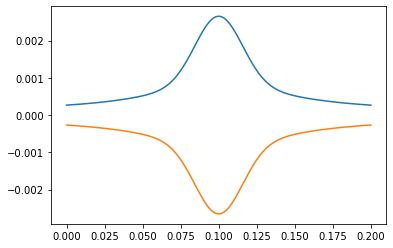

In [27]:
x_plt = np.linspace(0.0, 0.20, 1000)
one_m_kappa_plt =        [one_m_kappa_tree.evalf([x, 0.2, 0.3]) for x in x_plt]
kappa_plt =                    [kappa_tree.evalf([x, 0.2, 0.3])-1 for x in x_plt]
nuclear_potential_plt = [nuclear_potential.evalf([x, 0.2, 0.3]) for x in x_plt]
plt.plot(x_plt, kappa_plt)
plt.plot(x_plt, one_m_kappa_plt)
#plt.plot(x_plt, nuclear_potential_plt)

In [ ]:
# creating starting guess from a gaussian function

phi_n = vp.FunctionTree(MRA)
a_coeff = 3.0
b_coeff = np.sqrt(a_coeff/np.pi)**3
gauss = vp.GaussFunc(b_coeff, a_coeff, origin)
build_grid(phi_n, gauss)
project(prec, phi_n, gauss)
phi_n.normalize()

x_plt = np.linspace(-1.0, 1.0, 1000)
y_plt = [phi_n.evalf([x, 0.2, 0.3]) for x in x_plt]
plt.plot(x_plt, y_plt)

In [ ]:
energy = -1.0;
energy_correction = 1.0;

while np.abs(energy_correction) > prec/10:
#for i in range(10):
    phi_n.normalize()
    phi_np1 = vp.FunctionTree(MRA)

    temp1_tree = vp.FunctionTree(MRA)
    temp2_tree = vp.FunctionTree(MRA)
    multiply(prec, temp1_tree, 1.0, phi_n, nuclear_potential)

    mu = np.sqrt(-2*energy)
    H = vp.HelmholtzOperator(MRA, mu, prec)    
    apply(prec, phi_np1, H, temp1_tree)
    phi_np1.rescale(1.0/(2*np.pi))

    delta_phi = vp.FunctionTree(MRA)
    add(prec/10, delta_phi, 1.0, phi_np1, -1.0, phi_n)

    multiply(prec, temp2_tree, 1.0, delta_phi, nuclear_potential)
    energy_correction = dot(phi_np1, temp2_tree)/phi_np1.getSquareNorm()
    phi_n = vp.FunctionTree(MRA)
    copy_grid(phi_n, phi_np1)
    copy_func(phi_n, phi_np1)

    while abs(energy_correction) > abs(energy): 
        energy_correction /= 2
    
    energy -= energy_correction
    print("Energy ", energy)

In [ ]:
x_plt = np.linspace(-1.0, 1.0, 1000)
phi_np1_plt = [phi_np1.evalf([x, 0.2, 0.3]) for x in x_plt]
plt.plot(x_plt, phi_np1_plt)
phi_n.normalize()
print(phi_n)

In [ ]:
c = 137

def init_function(orbital, function, component):
    copy_grid(orbital[component], function)
    copy_func(orbital[component], function)
    
def init_empty_orbital():
    orbital = {'Lar': vp.FunctionTree(MRA),
               'Lai': vp.FunctionTree(MRA),
               'Lbr': vp.FunctionTree(MRA),
               'Lbi': vp.FunctionTree(MRA),
               'Sar': vp.FunctionTree(MRA),
               'Sai': vp.FunctionTree(MRA),
               'Sbr': vp.FunctionTree(MRA),
               'Sbi': vp.FunctionTree(MRA)}
    return orbital

def init_large_components(orbital, phi_lar=None, phi_lai=None, phi_lbr=None, phi_lbi=None):
    nr_of_functions = 0
    if(phi_lar != None):
        nr_of_functions += 1
        init_function(orbital, phi_lar, 'Lar')
    if(phi_lai != None):
        nr_of_functions += 1
        init_function(orbital, phi_lai, 'Lai')
    if(phi_lbr != None):
        nr_of_functions += 1
        init_function(orbital, phi_lbr, 'Lbr')
    if(phi_lbi != None):
        nr_of_functions += 1
        init_function(orbital, phi_lbi, 'Lbi')
    if(nr_of_functions == 0):
        print("WARNING: Large components not initialized!")

def init_small_components(orbital):
    # initalize the small components based on the kinetic balance
    D = vp.ABGVOperator(MRA, 0.0, 0.0)
    grad_ar = gradient(D, orbital['Lar'])
    grad_ai = gradient(D, orbital['Lai'])
    grad_br = gradient(D, orbital['Lbr'])
    grad_bi = gradient(D, orbital['Lbi'])
    sar_tree = vp.FunctionTree(MRA)    
    sai_tree = vp.FunctionTree(MRA)    
    sbr_tree = vp.FunctionTree(MRA)    
    sbi_tree = vp.FunctionTree(MRA)    
    sum_ar = []
    sum_ar.append(tuple([ 0.5/c, grad_bi[0][1]]))
    sum_ar.append(tuple([-0.5/c, grad_br[1][1]]))
    sum_ar.append(tuple([ 0.5/c, grad_ai[2][1]]))
    add(prec/10, sar_tree, sum_ar)
    sum_ai = []
    sum_ai.append(tuple([-0.5/c, grad_br[0][1]]))
    sum_ai.append(tuple([-0.5/c, grad_bi[1][1]]))
    sum_ai.append(tuple([-0.5/c, grad_ar[2][1]]))
    add(prec/10, sai_tree, sum_ai)
    sum_br = []
    sum_br.append(tuple([ 0.5/c, grad_ai[0][1]]))
    sum_br.append(tuple([ 0.5/c, grad_ar[1][1]]))
    sum_br.append(tuple([-0.5/c, grad_bi[2][1]]))
    add(prec/10, sbr_tree, sum_br)
    sum_bi = []
    sum_bi.append(tuple([-0.5/c, grad_ar[0][1]]))
    sum_bi.append(tuple([ 0.5/c, grad_ai[1][1]]))
    sum_bi.append(tuple([ 0.5/c, grad_br[2][1]]))
    add(prec/10, sbi_tree, sum_bi)
    init_function(orbital, sar_tree, 'Sar')
    init_function(orbital, sai_tree, 'Sai')
    init_function(orbital, sbr_tree, 'Sbr')
    init_function(orbital, sbi_tree, 'Sbi')
    return
    
def compute_orbital_gradient(orbital):
    D = vp.ABGVOperator(MRA, 0.0, 0.0)
    orb_grad = {}
    for comp, func in orbital.items():
        orb_grad[comp] = gradient(D, func) 
    return orb_grad

def grab_sign(comp, derivative):
    grab_table = {
        'Lar': ( 1, -1,  1), 
        'Lai': (-1, -1, -1), 
        'Lbr': ( 1,  1, -1), 
        'Lbi': (-1,  1,  1), 
        'Sar': ( 1, -1,  1), 
        'Sai': (-1, -1, -1), 
        'Sbr': ( 1,  1, -1), 
        'Sbi': (-1,  1,  1), 
    }
    return grab_table[comp][derivative]
    
def grab_coefficient(comp, derivative, global_factor = 1.0):
    grab_table = {
        'Lar': (c**2,c**2,c**2), 
        'Lai': (c**2,c**2,c**2),
        'Lbr': (c**2,c**2,c**2),
        'Lbi': (c**2,c**2,c**2),
        'Sar': (1, 1, 1), 
        'Sai': (1, 1, 1), 
        'Sbr': (1, 1, 1), 
        'Sbi': (1, 1, 1)
    }
    #return grab_table[comp][derivative] * global_factor
    return c
    
def grab_component(comp, derivative):
    grab_table = {
        'Lar': ('Sbi', 'Sbr', 'Sai'), 
        'Lai': ('Sbr', 'Sbi', 'Sar'), 
        'Lbr': ('Sai', 'Sar', 'Sbi'), 
        'Lbi': ('Sar', 'Sai', 'Sbr'), 
        'Sar': ('Lbi', 'Lbr', 'Lai'), 
        'Sai': ('Lbr', 'Lbi', 'Lar'), 
        'Sbr': ('Lai', 'Lar', 'Lbi'), 
        'Sbi': ('Lar', 'Lai', 'Lbr'), 
    }
    return grab_table[comp][derivative]
    
def assemble_vectors(orb, orb_grad, shift = 0.0):
    add_orbitals = {}
    for comp, func in orb.items():
        add_orbitals[comp] = []
        if('L' in comp):
            beta_factor = c**2 + shift
        else:
            beta_factor = -c**2 + shift            
        if(func.getSquareNorm() > 0):
            add_orbitals[comp].append((beta_factor, func))
        for idx in range(3):
            comp_der = grab_component(comp, idx)
            comp_sign = grab_sign(comp, idx)
            comp_coeff = grab_coefficient(comp, idx)
            if(orb_grad[comp_der][idx][1].getSquareNorm() > 0):
                tmp_tuple = (comp_sign * comp_coeff,orb_grad[comp_der][idx][1]) 
                add_orbitals[comp].append(tmp_tuple)
    return add_orbitals

def apply_dirac_hamiltonian(orbital, shift = 0.0):
    out_orbital = init_empty_orbital()
    orb_grad = compute_orbital_gradient(orbital)
    add_vectors = assemble_vectors(orbital, orb_grad, shift)
    for comp, func in out_orbital.items():
        add(prec/10, func, add_vectors[comp])
    return out_orbital

def apply_potential(nuclear_potential, orbital):
    out_orbital = init_empty_orbital()
    for comp, func in orbital.items():
        if func.getSquareNorm() > 0:
            multiply(prec, out_orbital[comp], -1.0, nuclear_potential, func)
    return out_orbital

def add_orbitals(a, orb_a, b, orb_b):
    out_orb = init_empty_orbital()
    for comp, func in out_orb.items():
        func_a = orb_a[comp]
        func_b = orb_b[comp]
        if (func_a.getSquareNorm() > 0 and func_b.getSquareNorm() > 0):
            add(prec/10, func, a, func_a, b, func_b)
        elif(func_a.getSquareNorm() > 0):
            init_function(out_orb, func_a, comp)
            func.rescale(a)
        elif(func_b.getSquareNorm() > 0):
            init_function(out_orb, func_b, comp)
            func.rescale(b)
        else:
            print('Warning: adding two empty trees')
    return out_orb

def scalar_product(orb_a, orb_b):
    out_real = 0
    out_imag = 0
    for comp in ['La','Lb','Sa','Sb']:
        factor = 1
#        if('S' in comp):
#            factor = c**2
        real_comp = comp + 'r'
        imag_comp = comp + 'i'
        ac = 0
        bd = 0
        ad = 0
        bc = 0
        func_a = orb_a[real_comp]
        func_b = orb_a[imag_comp]
        func_c = orb_b[real_comp]
        func_d = orb_b[imag_comp]
        if(func_a.getSquareNorm() > 0 and func_c.getSquareNorm() > 0):
           ac = dot(func_a, func_c)
        if(func_b.getSquareNorm() > 0 and func_d.getSquareNorm() > 0):
           bd = dot(func_b, func_d)
        if(func_a.getSquareNorm() > 0 and func_d.getSquareNorm() > 0):
           ad = dot(func_a, func_d)
        if(func_b.getSquareNorm() > 0 and func_c.getSquareNorm() > 0):
           bc = dot(func_b, func_c)
        out_real += (ac + bd) / factor
        out_imag += (ad - bc) / factor
    return out_real, out_imag

def init_1s_orbital(k,Z,alpha,origin):
    print(k,Z,alpha)
    orbital = init_empty_orbital()
    gamma_factor = compute_gamma(k,Z,alpha)
    norm_const = compute_norm_const(gamma_factor, Z)
    idx = 0
    for comp, func in orbital.items():
        print('Now projecting component ',comp,idx,alpha,gamma_factor,norm_const)
        analytic_func = lambda x: one_s_alpha_comp([x[0]-origin[0],x[1]-origin[1],x[2]-origin[2]],Z,alpha,gamma_factor,norm_const,idx)
        project(prec, func, analytic_func)
        idx += 1
    return orbital

def normalize_orbital(orbital):
    norm_sq, imag1 = scalar_product(orbital, orbital)
    norm = np.sqrt(norm_sq)
    rescale_orbital(orbital, 1.0/norm)

def apply_helmholtz(orbital, energy, c, prec):
    out_orbital = init_empty_orbital()
    mu = np.sqrt((c**4-energy**2)/c**2)
    #mu=1
    print('mu',mu)
    H = vp.HelmholtzOperator(MRA, mu, prec)
    for comp, func in orbital.items():
        if func.getSquareNorm() > 0:
            apply(prec, out_orbital[comp], H, func)
            out_orbital[comp].rescale(-1.0/(2*np.pi))
    return out_orbital

def rescale_orbital(orbital, factor):
    for comp,func in orbital.items():
        if func.getSquareNorm() > 0:
            func.rescale(factor)
            
def compute_density(orbital):
    density = vp.FunctionTree(MRA)
    add_vector = []
    for comp, func in orbital.items():
        if(func.getSquareNorm() > 0):
            temp = vp.FunctionTree(MRA)
            multiply(prec, temp, 1.0, func, func)
            add_vector.append((1.0,temp))
    add(prec/10, density, add_vector)
    print(add_vector)
    return density


In [ ]:
exact_orbital = init_1s_orbital(k,Z,alpha,origin)
normalize_orbital(exact_orbital)

In [ ]:
gaussian_orbital = init_empty_orbital()
init_large_components(gaussian_orbital,phi_n)
init_small_components(gaussian_orbital)
normalize_orbital(gaussian_orbital)
density = compute_density(gaussian_orbital)
print(density)
x_plt = np.linspace(-1.0, 1.0, 1000)
density_plt = [density.evalf([x, 0.2, 0.3]) for x in x_plt]
_ = plt.plot(x_plt, density_plt)

In [ ]:
orbital = gaussian_orbital
orbital_error = 1
while orbital_error > prec:
#for i in range(5):    
    hd_psi = apply_dirac_hamiltonian(orbital)
    v_psi = apply_potential(nuclear_potential, orbital)
    add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
    energy, imag = scalar_product(orbital, add_psi)
    print('Energy',energy)
    tmp = apply_helmholtz(v_psi, energy, c, prec)
    new_orbital = apply_dirac_hamiltonian(tmp, energy)
    normalize_orbital(new_orbital)
    delta_psi = add_orbitals(1.0, new_orbital, -1.0, orbital)
    orbital_error, imag = scalar_product(delta_psi, delta_psi)
    print('Error',orbital_error)
    orbital = new_orbital
    

hd_psi = apply_dirac_hamiltonian(orbital)
v_psi = apply_potential(nuclear_potential, orbital)
add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
energy, imag = scalar_product(orbital, add_psi)
print('Energy',energy)

In [ ]:
#hD_psi = apply_dirac_hamiltonian(orbital)
#v_psi = apply_potential(nuclear_potential, orbital)
#add_psi = add_orbitals(1.0, hD_psi, 1.0, v_psi)
#norm_sq_add_psi, imag1 = scalar_product(add_psi, add_psi)
#orbital_dot_add_psi, imag2 = scalar_product(orbital, add_psi)
#exact_energy = compute_dirac_energy(1,1,-1,1.0/c)
#energy = orbital_dot_add_psi
#normalize_orbital(add_psi)

v_psi = apply_potential(nuclear_potential, gaussian_orbital)
tmp = apply_dirac_hamiltonian(v_psi, energy)
out_orb = apply_helmholtz(tmp, energy, c, prec)
normalize_orbital(out_orb)

#print('C square', c**2)
#print('Exact energy', exact_energy, 'computed energy', energy, 'difference', exact_energy - energy)
#print('Exact energy', exact_energy-c**2, 'computed energy', energy, 'difference', exact_energy - energy-c**2)

In [ ]:
#for comp, func in add_psi.items():
#    if (func.getSquareNorm() > 0):
#        refine_grid(func,1)

fig, axs = plt.subplots(2,2,figsize=(10, 10))
axs[0,0].set_box_aspect(1)
axs[0,1].set_box_aspect(1)
axs[1,0].set_box_aspect(1)
axs[1,1].set_box_aspect(1)
x_plt = np.linspace(-1, 1, 1000)
orbital_plt = {}
exact_plt = {}
out_plt = {}
orb_plt = {}
add_psi_plt = {}
exact_plt['Lar'] = [exact_orbital['Lar'].evalf([x+origin[0], 0.0+origin[1], 0.0+origin[2]]) for x in x_plt]
exact_plt['Sai'] = [exact_orbital['Sai'].evalf([0.0+origin[0], 0.0+origin[1], x+origin[2]]) for x in x_plt]
exact_plt['Sbr'] = [exact_orbital['Sbr'].evalf([0.0+origin[0], x+origin[1], 0.0+origin[2]]) for x in x_plt]
exact_plt['Sbi'] = [exact_orbital['Sbi'].evalf([x+origin[0], 0.0+origin[1], 0.0+origin[2]]) for x in x_plt]
out_plt['Lar'] = [out_orb['Lar'].evalf([x+origin[0], 0.0+origin[1], 0.0+origin[2]]) for x in x_plt]
out_plt['Sai'] = [out_orb['Sai'].evalf([0.0+origin[0], 0.0+origin[1], x+origin[2]]) for x in x_plt]
out_plt['Sbr'] = [out_orb['Sbr'].evalf([0.0+origin[0], x+origin[1], 0.0+origin[2]]) for x in x_plt]
out_plt['Sbi'] = [out_orb['Sbi'].evalf([x+origin[0], 0.0+origin[1], 0.0+origin[2]]) for x in x_plt]
orb_plt['Lar'] = [orbital['Lar'].evalf([x+origin[0], 0.0+origin[1], 0.0+origin[2]]) for x in x_plt]
orb_plt['Sai'] = [orbital['Sai'].evalf([0.0+origin[0], 0.0+origin[1], x+origin[2]]) for x in x_plt]
orb_plt['Sbr'] = [orbital['Sbr'].evalf([0.0+origin[0], x+origin[1], 0.0+origin[2]]) for x in x_plt]
orb_plt['Sbi'] = [orbital['Sbi'].evalf([x+origin[0], 0.0+origin[1], 0.0+origin[2]]) for x in x_plt]
orbital_plt['Lar'] = [gaussian_orbital['Lar'].evalf([x+origin[0], 0.0+origin[1], 0.0+origin[2]]) for x in x_plt]
orbital_plt['Sai'] = [gaussian_orbital['Sai'].evalf([0.0+origin[0], 0.0+origin[1], x+origin[2]]) for x in x_plt]
orbital_plt['Sbr'] = [gaussian_orbital['Sbr'].evalf([0.0+origin[0], x+origin[1], 0.0+origin[2]]) for x in x_plt]
orbital_plt['Sbi'] = [gaussian_orbital['Sbi'].evalf([x+origin[0], 0.0+origin[1], 0.0+origin[2]]) for x in x_plt]
add_psi_plt['Lar'] = [add_psi['Lar'].evalf([x+origin[0], 0.0+origin[1], 0.0+origin[2]]) for x in x_plt]
add_psi_plt['Sai'] = [add_psi['Sai'].evalf([0.0+origin[0], 0.0+origin[1], x+origin[2]]) for x in x_plt]
add_psi_plt['Sbr'] = [add_psi['Sbr'].evalf([0.0+origin[0], x+origin[1], 0.0+origin[2]]) for x in x_plt]
add_psi_plt['Sbi'] = [add_psi['Sbi'].evalf([x+origin[0], 0.0+origin[1], 0.0+origin[2]]) for x in x_plt]
#plt.plot(x_plt, [add_psi_plt['Lar'][i]/orbital_plt['Lar'][i] for i in range(1000)])
#axs[0,0].plot(x_plt, add_psi_plt['Lar'],label='add_psi')
axs[0,0].plot(x_plt, orbital_plt['Lar'],label='gaussian')
axs[0,0].plot(x_plt, exact_plt['Lar'],label='exact')
axs[0,0].plot(x_plt, out_plt['Lar'],label='out (1 iter)')
axs[0,0].plot(x_plt, orb_plt['Lar'],label='out (err 10^-5)')
axs[0,0].legend()
#axs[0,1].plot(x_plt, add_psi_plt['Sai'],label='add_psi')
axs[0,1].plot(x_plt, orbital_plt['Sai'],label='gaussian')
axs[0,1].plot(x_plt, exact_plt['Sai'],label='exact')
axs[0,1].plot(x_plt, out_plt['Sai'],label='out (1 iter)')
axs[0,1].plot(x_plt, orb_plt['Sai'],label='out (err 10^-5)')
axs[0,1].legend()
#axs[1,0].plot(x_plt, add_psi_plt['Sbr'],label='add_psi')
axs[1,0].plot(x_plt, orbital_plt['Sbr'],label='gaussian')
axs[1,0].plot(x_plt, exact_plt['Sbr'],label='exact')
axs[1,0].plot(x_plt, out_plt['Sbr'],label='out (1 iter)')
axs[1,0].plot(x_plt, orb_plt['Sbr'],label='out (err 10^-5)')
axs[1,0].legend()
#axs[1,1].plot(x_plt, add_psi_plt['Sbi'],label='add_psi')
axs[1,1].plot(x_plt, orbital_plt['Sbi'],label='gaussian')
axs[1,1].plot(x_plt, exact_plt['Sbi'],label='exact')
axs[1,1].plot(x_plt, out_plt['Sbi'],label='out (1 iter)')
axs[1,1].plot(x_plt, orb_plt['Sbi'],label='out (err 10^-5)')
axs[1,1].legend()
#axs[0,0].set_ylim(0, 1)
#axs[0,1].set_ylim(-0.01, 0.01)
#axs[1,0].set_ylim(-0.01, 0.01)
#axs[1,1].set_ylim(-0.01, 0.01)
#plt.plot(x_plt, y_plt)